In [109]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# misc
import warnings

import glob

##
import pytz
import datetime as dt
import math
import seaborn as sns

import pickle

In [110]:

#style settings
sns.set(style='whitegrid', rc={'axes.facecolor': 'white'})

#sns.set_style({'font.family':'Arial', 'font.serif':'Times New Roman'})

## Time Domain analysis

In [111]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

## Related functions

In [112]:
def get_non_nan_values_cols(p_df, col_name):
    
    slic_ind=p_df[col_name].isnull()
    list_ne=slic_ind.tolist()
    false_indices = [i for i in range(len(list_ne)) if not list_ne[i]]
    
    list_col_interest=p_df[col_name].to_list()
    
    non_values_list = []
    
    for false_ind in false_indices:
        non_val = list_col_interest[false_ind]
        non_values_list.append(non_val)
    
    return non_values_list


def get_file_names_from_ind_list(files_list, inds_list):
    
    selected_files_list=[files_list[sel_index] for sel_index in inds_list]
    
    return selected_files_list


In [113]:
def select_pickled_condition_files(path_pickled_files_list, cond_file_names_list):
    selected_file_cond_list = []
    
    for selected_file_path in path_pickled_files_list:
        dir_path, file_name=os.path.split(selected_file_path)
        sub_id = file_name[0:12]
    
        for cond_file in cond_file_names_list:
        
            if sub_id==cond_file:
            
                selected_file_cond_list.append(selected_file_path)
                #print(selected_file_path)
                
    return selected_file_cond_list

In [114]:
def min_max_norm(all_rr_one_list, all_rr_sublist):
    
    mean_norm_list =[]
    std_norm_list = []
    
    mean_norm_bpm_list = []
    std_norm_bpm_list = []
    
    all_rr_one_list = np.array(all_rr_one_list)
    max_val = np.max(all_rr_one_list)
    min_val =np.min(all_rr_one_list)
    
    range_list = max_val-min_val
    
    ####-------beats per minutes--------
    bpm_one_list = 60000/all_rr_one_list
    
    max_bpm = np.max(bpm_one_list)
    
    min_bpm = np.min(bpm_one_list)
    
    range_bpm =  max_bpm - min_bpm
    
    
    for sel_list in all_rr_sublist:
        
        sel_list_np = np.array(sel_list)
        
        
        
        sel_lis_np_sub = sel_list_np - min_val
        
        sel_lis_norm= sel_lis_np_sub/range_list
        
        mean_norm = np.mean(sel_lis_norm)
        mean_norm_list.append(mean_norm)
        
        std_norm  = np.std(sel_lis_norm)   
        std_norm_list.append(std_norm)
        
        ##------------for normalized BPM----------
        
        sel_list_bpm = 60000/sel_list_np
        
        
        
        sel_bpm_min_sub = sel_list_bpm - min_bpm
        
        sel_bpm_list_norm =  sel_bpm_min_sub/ range_bpm
        
        mean_norm_bpm = np.mean(sel_bpm_list_norm)
        
        std_norm_bpm = np.std(sel_bpm_list_norm)
        
        mean_norm_bpm_list.append(mean_norm_bpm)
        
        std_norm_bpm_list.append(std_norm_bpm)
        
        
        
        
        #print(mean_norm)
        #print(std_norm)
                
        
    return mean_norm_list, std_norm_list, mean_norm_bpm_list, std_norm_bpm_list

In [115]:
def split_bpm(mean_bpm_list):
    
    base_line = mean_bpm_list[0]
    tsst  = np.mean(mean_bpm_list[1:4])
    relax = np.mean(mean_bpm_list[4:])
    
    #tsst  = max(mean_bpm_list[1:4])
    #relax = min(mean_bpm_list[4:])

    new_array = [base_line,tsst, relax]
    
    return new_array

In [116]:
def get_cumsum_cond(input_array):
    
    mean_diff = np.diff(input_array)
    
    mean_diff = np.insert(mean_diff, [0], 0)
    
    mean_diff_cumsum = np.cumsum(mean_diff, dtype=float)
    
    return (mean_diff_cumsum)

In [117]:

def calc_rate_change_percent(cond_phy_array):
    
    prev_val = cond_phy_array[1]
    curr_val = cond_phy_array[2]
    change_val=((curr_val-prev_val)/abs(prev_val))
    change_percent = change_val*100
    #print(change_percent)
    
    return change_percent

In [118]:
def from_rr_to_time_anal(selected_path):
                 
    with open(selected_path, 'rb') as f:
        ibi_data = pickle.load(f)
                    
                    
    subject_id = ibi_data["subject_id"]
    event_interst = ibi_data["event_interst"]
    all_rr_one_list = ibi_data["all_rr_one_list"]
    all_rr_sublists = ibi_data["all_rr_sublists"]
            
    max_rr = np.max(all_rr_one_list)
    #print(max_rr)
    min_rr = np.min(all_rr_one_list)
    #print(min_rr)
    range_rr = max_rr - min_rr    
            
    mean_rr_cumm_list = []
    std_rr_cumm_list  = []
    mean_hr_list = []
    std_hr_list = []
            
    for index, selected_event in enumerate(event_interst):
        sel_rr = all_rr_sublists[index]
                
        #### heart rate from RR ineterval
        hr_from_rr = 60000/sel_rr
        mean_hr = np.mean(hr_from_rr)
        std_hr = np.std(hr_from_rr)
        mean_hr_list.append(mean_hr)
        std_hr_list.append(std_hr)
                
        ##### mean and std rr
        mean_rr = np.mean(sel_rr)     
        std_rr = np.std(sel_rr)
        mean_rr_cumm_list.append(mean_rr)
        std_rr_cumm_list.append(std_rr)
                
                
    mean_norm_hrv_list, std_norm_hrv_list,  mean_norm_bpm_list, std_norm_bpm_list = min_max_norm(all_rr_one_list, all_rr_sublists)
            
    export_dict= {"subject_id":subject_id , 'event_interst': event_interst, "mean_bpm": mean_hr_list, "std_bpm":std_hr_list , 
                              "mean_ibi":mean_rr_cumm_list , "std_ibi": std_rr_cumm_list , "norm_mean_ibi":mean_norm_hrv_list,  "norm_std_ibi": std_norm_hrv_list,
                             "norm_mean_bpm":mean_norm_bpm_list, "norm_std_bpm":  std_norm_bpm_list}
            
            
    return export_dict

In [119]:
def plot_info_time_domain(files_path_list):
    
    
    ###---------Keys of Interest--------
    mean_bpm ="mean_bpm"
    std_bpm = "std_bpm"

    mean_bpm_norm = "norm_mean_bpm"
    std_bpm_norm = "norm_std_bpm"

    ####--------------------

    mean_ibi = "mean_ibi"
    std_ibi = "std_ibi"

    mean_ibi_norm ="norm_mean_ibi"
    std_ibi_norm = "norm_std_ibi"
        
    #######------------cummulate the results
    mean_bpm_cumm=[]
    std_bpm_cumm=[]
    
    mean_bpm_norm_cumm=[]
    std_bpm_norm_cumm = []
    
    
    mean_ibi_cumm = []
    std_ibi_cumm = []
    
    mean_ibi_norm_cumm = []
    std_ibi_norm_cumm = []
    
    for sel_file in files_path_list:
        
        exported_dict=from_rr_to_time_anal(sel_file)
        
        mean_ibi_current = exported_dict[mean_ibi]
        std_ibi_current = exported_dict[std_ibi]
        
        mean_ibi_norm_current = exported_dict[mean_ibi_norm]
        std_ibi_norm_current = exported_dict[std_ibi_norm]
        
        mean_bpm_current = exported_dict[mean_bpm]
        std_bpm_current = exported_dict[std_bpm]
        
        mean_bpm_norm_current = exported_dict[mean_bpm_norm]
        std_bpm_norm_current = exported_dict[std_bpm_norm]
        
        
        mean_bpm_cumm.append(mean_bpm_current)
        std_bpm_cumm.append(std_bpm_current)
        
        mean_bpm_norm_cumm.append(mean_bpm_norm_current)
        std_bpm_norm_cumm.append(std_bpm_norm_current)
        
        mean_ibi_cumm.append(mean_ibi_current)
        std_ibi_cumm.append(std_ibi_current)
        mean_ibi_norm_cumm.append(mean_ibi_norm_current)
        std_ibi_norm_cumm.append(std_ibi_norm_current)
        
        
    mean_bpm_cumm=np.mean(mean_bpm_cumm, axis=0)
    std_bpm_cumm = np.mean(std_bpm_cumm, axis=0)
    
    mean_bpm_norm_cumm = np.mean(mean_bpm_norm_cumm, axis=0)
    std_bpm_norm_cumm = np.mean(std_bpm_norm_cumm, axis=0)
    
    mean_ibi_cumm = np.mean(mean_ibi_cumm, axis=0)
    std_ibi_cumm = np.mean(mean_ibi_cumm, axis=0)
    
    mean_ibi_norm_cumm = np.mean(mean_ibi_norm_cumm, axis = 0)
    std_ibi_norm_cumm = np.mean(std_ibi_norm_cumm, axis=0)
    
    
    return mean_bpm_cumm, std_bpm_cumm, mean_bpm_norm_cumm, std_bpm_norm_cumm, mean_ibi_cumm, std_ibi_cumm, mean_ibi_norm_cumm, std_ibi_norm_cumm

In [120]:

#sub_data_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp4/subjective_data/DigiR_subj_final_250124.xlsx"
sub_data_path = "C:/Users/muhammad.saif/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp4/subjective_data/DigiR_subj_final_250124.xlsx"

hrv_data_dir = "C:/Users/muhammad.saif/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp4/results_all_sub/hrv/ibi_filtered_pkl"
#hrv_data_dir = "/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp4/results_all_sub/hrv/ibi_filtered_pkl"

In [121]:
sk_hr_files_list = glob.glob(hrv_data_dir+ "/*.pkl")

In [122]:
sub_data_df=pd.read_excel(sub_data_path)
file_col = "subject"
cond_col ="condition"

file_list = get_non_nan_values_cols(sub_data_df,file_col)
cond_list = get_non_nan_values_cols(sub_data_df, cond_col)

cond_set=set(cond_list)
unique_conds_list= list(cond_set)

In [123]:
no_scent_2d_inds=np.where(np.array(cond_list)=="2D_no_scent")
no_scent_2d_inds = list(no_scent_2d_inds[0])
no_scent_2d_files =get_file_names_from_ind_list(file_list, no_scent_2d_inds)
no_scent_2d_path_list = select_pickled_condition_files(sk_hr_files_list, no_scent_2d_files)

scent_2d_inds=np.where(np.array(cond_list)=="2D_scent")
scent_2d_inds=list(scent_2d_inds[0])
scent_2d_files=get_file_names_from_ind_list(file_list, scent_2d_inds)
scent_2d_path_list = select_pickled_condition_files(sk_hr_files_list, scent_2d_files)


no_scent_vr_inds = np.where(np.array(cond_list)=="VR_no_scent")
no_scent_vr_inds=list(no_scent_vr_inds[0])
no_scent_vr_files=get_file_names_from_ind_list(file_list, no_scent_vr_inds)
no_scent_vr_path_list = select_pickled_condition_files(sk_hr_files_list, no_scent_vr_files)

scent_vr_inds =np.where(np.array(cond_list)=="VR_scent")
scent_vr_inds =list(scent_vr_inds[0])
scent_vr_files=get_file_names_from_ind_list(file_list, scent_vr_inds)
scent_vr_path_list = select_pickled_condition_files(sk_hr_files_list, scent_vr_files)


In [124]:
print("Total scent vr files:" + str(len(scent_vr_path_list)))
print("Total scent 2d files:" + str(len(scent_2d_path_list)))
print("Total non-scent vr files:" + str(len(no_scent_vr_path_list)))
print("Total non-scent 2d files:" + str(len(no_scent_2d_path_list)))

Total scent vr files:15
Total scent 2d files:15
Total non-scent vr files:18
Total non-scent 2d files:15


In [125]:
mean_bpm_scent_vr,std_bpm_scent_vr, mean_norm_bpm_scent_vr,std_norm_bpm_scent_vr, mean_ibi_scent_vr, std_ibi_scent_vr, mean_norm_ibi_scent_vr, std_norm_ibi_scent_vr= plot_info_time_domain(scent_vr_path_list)
mean_bpm_scent_2d,std_bpm_scent_2d, mean_norm_bpm_scent_2d,std_norm_bpm_scent_2d, mean_ibi_scent_2d, std_ibi_scent_2d, mean_norm_ibi_scent_2d, std_norm_ibi_scent_2d= plot_info_time_domain(scent_2d_path_list)
mean_bpm_no_scent_vr,std_bpm_no_scent_vr, mean_norm_bpm_no_scent_vr,std_norm_bpm_no_scent_vr, mean_ibi_no_scent_vr, std_ibi_no_scent_vr, mean_norm_ibi_no_scent_vr, std_norm_ibi_no_scent_vr= plot_info_time_domain(no_scent_vr_path_list)
mean_bpm_no_scent_2d,std_bpm_no_scent_2d, mean_norm_bpm_no_scent_2d,std_norm_bpm_no_scent_2d, mean_ibi_no_scent_2d, std_ibi_no_scent_2d, mean_norm_ibi_no_scent_2d, std_norm_ibi_no_scent_2d= plot_info_time_domain(no_scent_2d_path_list)

## ----- Plot BPM 

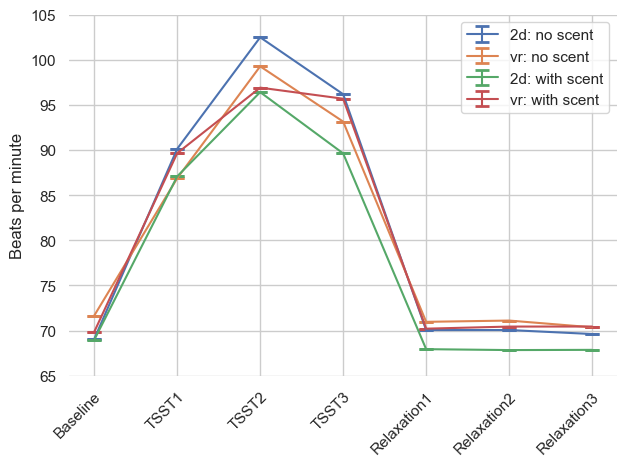

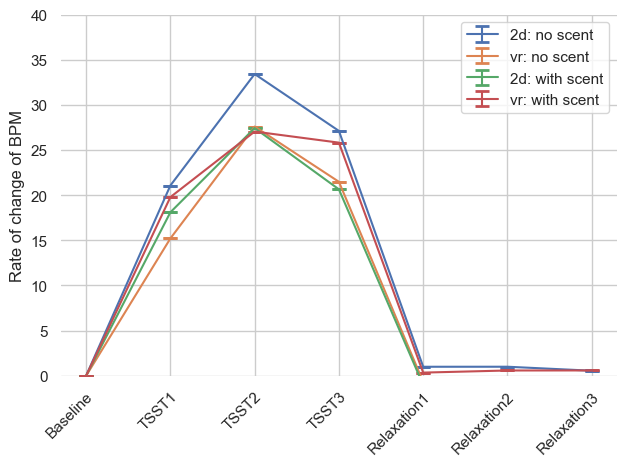

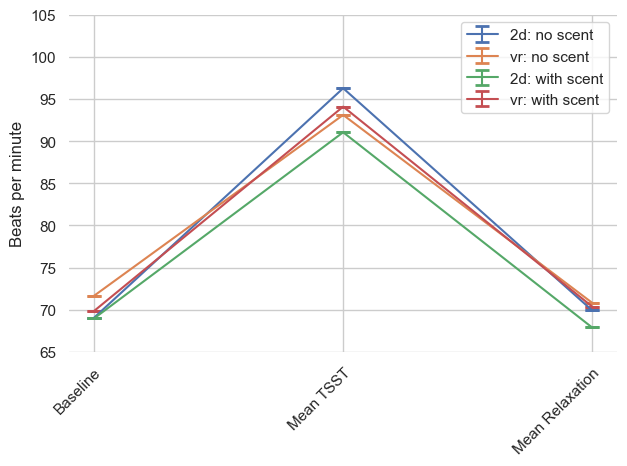

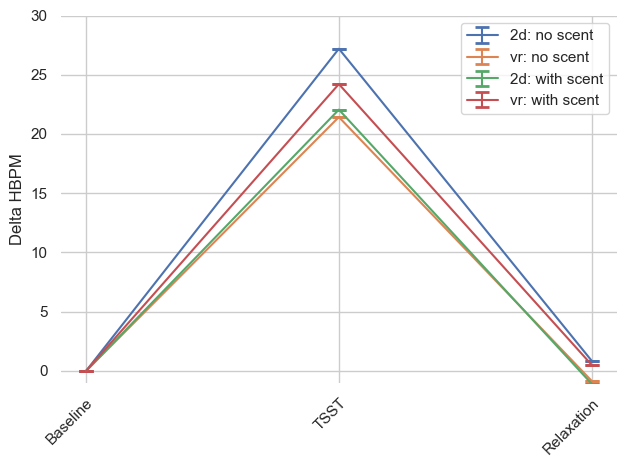

In [126]:
import matplotlib.pyplot as mpl
mpl.rcParams['font.size'] = 11
#mpl.rcParams["font.family"]="cursive"

x_labels = ["Baseline", "TSST1", "TSST2", "TSST3", "Relaxation1", "Relaxation2", "Relaxation3"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots()
    
ax.errorbar(x_pos,  list(mean_bpm_no_scent_2d),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_bpm_no_scent_vr),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_bpm_scent_2d),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_bpm_scent_vr),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Beats per minute")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(65, 105) 
plt.tight_layout()
plt.show()


#####-----------------------------------------------------
######---------------------------------------------




mean_bpm_no_scent_2d_slope=get_cumsum_cond(mean_bpm_no_scent_2d)
mean_bpm_no_scent_vr_slope =get_cumsum_cond(mean_bpm_no_scent_vr)
mean_bpm_scent_2d_slope = get_cumsum_cond(mean_bpm_scent_2d)
mean_bpm_scent_vr_slope =get_cumsum_cond(mean_bpm_scent_vr)



fig, ax = plt.subplots()
    
ax.errorbar(x_pos,  list(mean_bpm_no_scent_2d_slope),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_bpm_no_scent_vr_slope),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_bpm_scent_2d_slope),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_bpm_scent_vr_slope),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Rate of change of BPM")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(0, 40) 
plt.tight_layout()
plt.show()

#####--------------------------------------------------------------------------------------------------
#################--------------------------------Baseline, Stress, relaxation--------------------------------
####--------------------------------------------------------------------------------------------------

x_labels = ["Baseline", "Mean TSST", "Mean Relaxation"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots()
 
mean_bpm_no_scent_2d_short = split_bpm (mean_bpm_no_scent_2d)
mean_bpm_no_scent_vr_short =split_bpm(mean_bpm_no_scent_vr) 
mean_bpm_scent_2d_short = split_bpm(mean_bpm_scent_2d)
mean_bpm_scent_vr_short = split_bpm(mean_bpm_scent_vr)


ax.errorbar(x_pos,  list(mean_bpm_no_scent_2d_short),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_bpm_no_scent_vr_short),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_bpm_scent_2d_short),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_bpm_scent_vr_short),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Beats per minute")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(65, 105) 
plt.tight_layout()
plt.show()

x_labels = ["Baseline", "TSST", "Relaxation"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots()

mean_bpm_no_scent_2d_short_slope=get_cumsum_cond(mean_bpm_no_scent_2d_short)
mean_bpm_no_scent_vr_short_slope =get_cumsum_cond(mean_bpm_no_scent_vr_short)
mean_bpm_scent_2d_short_slope = get_cumsum_cond(mean_bpm_scent_2d_short)
mean_bpm_scent_vr_short_slope =get_cumsum_cond(mean_bpm_scent_vr_short)

ax.errorbar(x_pos,  list(mean_bpm_no_scent_2d_short_slope),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_bpm_no_scent_vr_short_slope),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_bpm_scent_2d_short_slope),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_bpm_scent_vr_short_slope),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Delta HBPM")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(-1, 30) 
plt.tight_layout()
plt.show()


In [127]:

    
    
#calc_rate_change_percent(mean_bpm_scent_2d_short)
    

In [128]:
no_scent_2d_change=calc_rate_change_percent(mean_bpm_no_scent_2d_short_slope) 
no_scent_vr_change=calc_rate_change_percent(mean_bpm_no_scent_vr_short_slope) 
scent_2d_change=calc_rate_change_percent(mean_bpm_scent_2d_short_slope)
scent_vr_change=calc_rate_change_percent(mean_bpm_scent_vr_short_slope)

In [129]:
mean_bpm_scent_2d_short

[68.97775960317792, 91.03422473412655, 67.89030912430583]

In [130]:
print ("change of HBPM from stress to relaxation, scent vr: " + str(scent_vr_change) +" %")
print ("change of HBPM from stress to relaxation, no scent vr: " + str(no_scent_vr_change) +" %")
print ("change of HBPM from stress to relaxation, scent 2d: " + str(scent_2d_change) +" %")
print ("change of HBPM from stress to relaxation, no scent 2d: " + str(no_scent_2d_change) +" %")


change of HBPM from stress to relaxation, scent vr: -97.8838964452829 %
change of HBPM from stress to relaxation, no scent vr: -103.92922559771189 %
change of HBPM from stress to relaxation, scent 2d: -104.93030262290861 %
change of HBPM from stress to relaxation, no scent 2d: -96.85110159293258 %


## Plot Normalized BPM

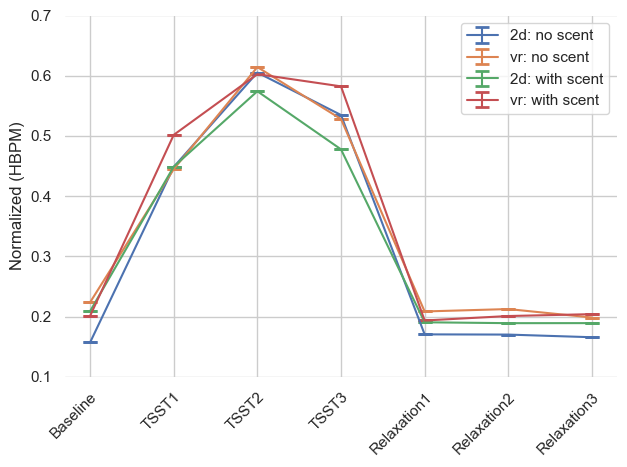

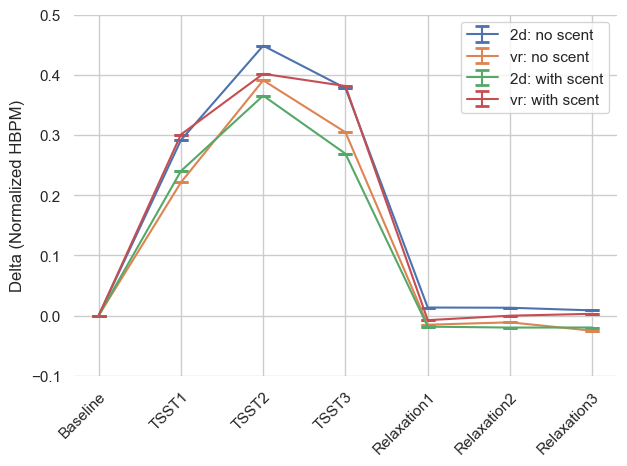

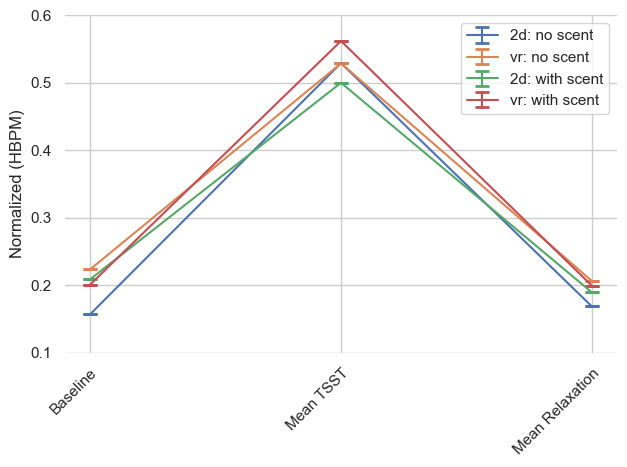

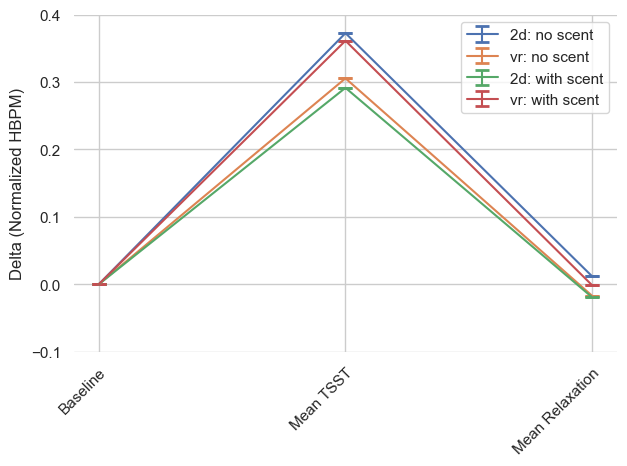

In [131]:
import matplotlib.pyplot as mpl
mpl.rcParams['font.size'] = 11
#mpl.rcParams["font.family"]="cursive"

x_labels = ["Baseline", "TSST1", "TSST2", "TSST3", "Relaxation1", "Relaxation2", "Relaxation3"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots()
    
ax.errorbar(x_pos,  list(mean_norm_bpm_no_scent_2d),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_norm_bpm_no_scent_vr),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_norm_bpm_scent_2d),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_norm_bpm_scent_vr),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Normalized (HBPM)")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(0.1, 0.7) 
plt.tight_layout()
plt.show()

#######--------------------------------------------------------
#####--------------------------------------------------------
######------------------------------------------------------

mean_norm_bpm_no_scent_2d_slope=get_cumsum_cond(mean_norm_bpm_no_scent_2d)
mean_norm_bpm_no_scent_vr_slope =get_cumsum_cond(mean_norm_bpm_no_scent_vr)
mean_norm_bpm_scent_2d_slope = get_cumsum_cond(mean_norm_bpm_scent_2d)
mean_norm_bpm_scent_vr_slope =get_cumsum_cond(mean_norm_bpm_scent_vr)

fig, ax = plt.subplots()
    
ax.errorbar(x_pos,  list(mean_norm_bpm_no_scent_2d_slope),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_norm_bpm_no_scent_vr_slope),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_norm_bpm_scent_2d_slope),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_norm_bpm_scent_vr_slope),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Delta (Normalized HBPM)")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(-0.1, 0.5) 
plt.tight_layout()
plt.show()



#####--------------------------------------------------------------------------------------------------
#################--------------------------------Baseline, Stress, relaxation--------------------------------
####--------------------------------------------------------------------------------------------------

x_labels = ["Baseline", "Mean TSST", "Mean Relaxation"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots()
 
mean_norm_bpm_no_scent_2d_short = split_bpm (mean_norm_bpm_no_scent_2d)
mean_norm_bpm_no_scent_vr_short =split_bpm(mean_norm_bpm_no_scent_vr) 
mean_norm_bpm_scent_2d_short = split_bpm(mean_norm_bpm_scent_2d)
mean_norm_bpm_scent_vr_short = split_bpm(mean_norm_bpm_scent_vr)

ax.errorbar(x_pos,  list(mean_norm_bpm_no_scent_2d_short),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_norm_bpm_no_scent_vr_short),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_norm_bpm_scent_2d_short),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_norm_bpm_scent_vr_short),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Normalized (HBPM)")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(0.1, 0.6) 
plt.tight_layout()
plt.show()

######-------------------------------------------------------------------------
#######------------------------------------------------------------------------
#######------------------------------------------------------------------------
fig, ax = plt.subplots()

mean_norm_bpm_no_scent_2d_short_slope=get_cumsum_cond(mean_norm_bpm_no_scent_2d_short)
mean_norm_bpm_no_scent_vr_short_slope =get_cumsum_cond(mean_norm_bpm_no_scent_vr_short)
mean_norm_bpm_scent_2d_short_slope = get_cumsum_cond(mean_norm_bpm_scent_2d_short)
mean_norm_bpm_scent_vr_short_slope =get_cumsum_cond(mean_norm_bpm_scent_vr_short)

ax.errorbar(x_pos,  list(mean_norm_bpm_no_scent_2d_short_slope),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_norm_bpm_no_scent_vr_short_slope),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_norm_bpm_scent_2d_short_slope),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_norm_bpm_scent_vr_short_slope),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Delta (Normalized HBPM)")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(-0.1, 0.4) 
plt.tight_layout()
plt.show()


In [132]:
no_scent_2d_mean_change=calc_rate_change_percent(mean_norm_bpm_no_scent_2d_short_slope) 
no_scent_vr_mean_change=calc_rate_change_percent(mean_norm_bpm_no_scent_vr_short_slope) 
scent_2d_mean_change=calc_rate_change_percent(mean_norm_bpm_scent_2d_short_slope)
scent_vr_mean_change=calc_rate_change_percent(mean_norm_bpm_scent_vr_short_slope)

In [133]:
print ("change of HBPM from stress to relaxation, scent vr: " + str(scent_vr_mean_change) +" %")
print ("change of HBPM from stress to relaxation, no scent vr: " + str(no_scent_vr_mean_change) +" %")
print ("change of HBPM from stress to relaxation, scent 2d: " + str(scent_2d_mean_change) +" %")
print ("change of HBPM from stress to relaxation, no scent 2d: " + str(no_scent_2d_mean_change) +" %")

change of HBPM from stress to relaxation, scent vr: -100.43980339935545 %
change of HBPM from stress to relaxation, no scent vr: -105.62376519272706 %
change of HBPM from stress to relaxation, scent 2d: -106.64215516900377 %
change of HBPM from stress to relaxation, no scent 2d: -96.86052105628221 %


# --- Plot IBI or HRV

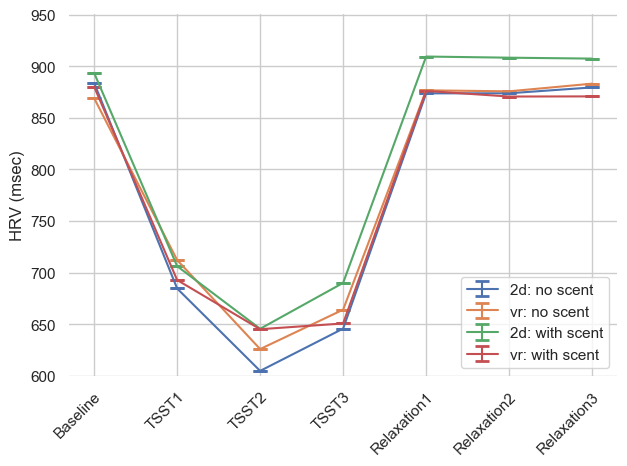

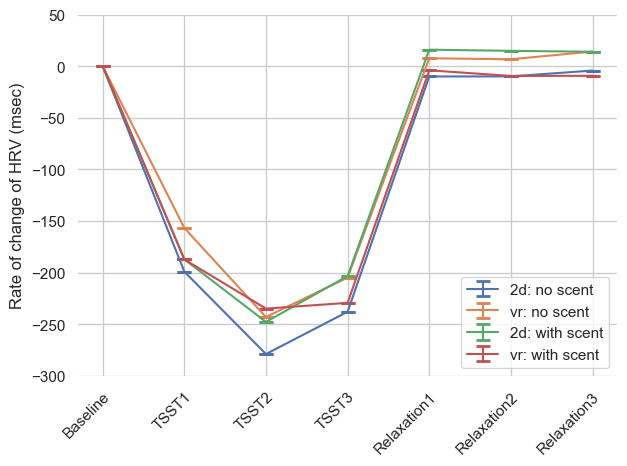

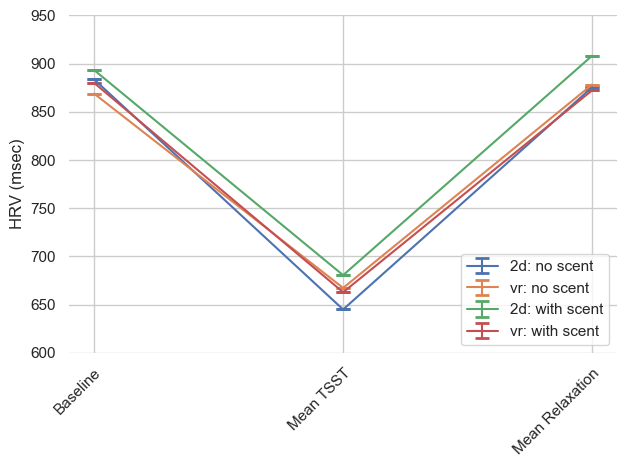

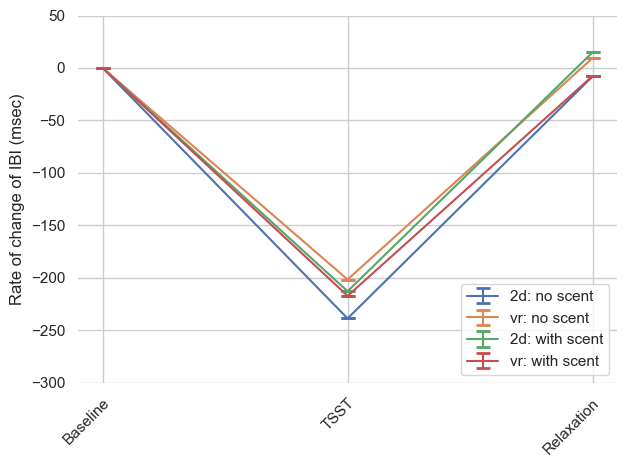

In [134]:

#mpl.rcParams["font.family"]="cursive"

x_labels = ["Baseline", "TSST1", "TSST2", "TSST3", "Relaxation1", "Relaxation2", "Relaxation3"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots()
    
ax.errorbar(x_pos,  list(mean_ibi_no_scent_2d),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_ibi_no_scent_vr),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_ibi_scent_2d),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_ibi_scent_vr),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("HRV (msec)")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.ylim(600, 950) 
plt.tight_layout()
plt.show()

#####------------------------------------------------------
######-------------Rate of change of IBI-------------------
######-----------------------------------------------------
mean_ibi_no_scent_2d_slope=get_cumsum_cond(mean_ibi_no_scent_2d)
mean_ibi_no_scent_vr_slope =get_cumsum_cond(mean_ibi_no_scent_vr)
mean_ibi_scent_2d_slope = get_cumsum_cond(mean_ibi_scent_2d)
mean_ibi_scent_vr_slope =get_cumsum_cond(mean_ibi_scent_vr)



fig, ax = plt.subplots()    
ax.errorbar(x_pos,  list(mean_ibi_no_scent_2d_slope),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_ibi_no_scent_vr_slope),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_ibi_scent_2d_slope),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_ibi_scent_vr_slope),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Rate of change of HRV (msec)")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.ylim(-300, 50) 
plt.tight_layout()
plt.show()


#####--------------------------------------------------------------------------------------------------
#################--------------------------------Baseline, Stress, relaxation--------------------------------
####--------------------------------------------------------------------------------------------------

x_labels = ["Baseline", "Mean TSST", "Mean Relaxation"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots()
 
mean_ibi_no_scent_2d_short = split_bpm (mean_ibi_no_scent_2d)
mean_ibi_no_scent_vr_short =split_bpm(mean_ibi_no_scent_vr) 
mean_ibi_scent_2d_short = split_bpm(mean_ibi_scent_2d)
mean_ibi_scent_vr_short = split_bpm(mean_ibi_scent_vr)

ax.errorbar(x_pos,  list(mean_ibi_no_scent_2d_short),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_ibi_no_scent_vr_short),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_ibi_scent_2d_short),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_ibi_scent_vr_short),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("HRV (msec)")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.ylim(600, 950) 
plt.tight_layout()
plt.show()


#####------------------------------------------------------
######-------------Rate of change of IBI-------------------
######-----------------------------------------------------
x_labels = ["Baseline", "TSST", "Relaxation"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots()

mean_ibi_no_scent_2d_short_slope=get_cumsum_cond(mean_ibi_no_scent_2d_short)
mean_ibi_no_scent_vr_short_slope =get_cumsum_cond(mean_ibi_no_scent_vr_short)
mean_ibi_scent_2d_short_slope = get_cumsum_cond(mean_ibi_scent_2d_short)
mean_ibi_scent_vr_short_slope =get_cumsum_cond(mean_ibi_scent_vr_short)

ax.errorbar(x_pos,  list(mean_ibi_no_scent_2d_short_slope),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_ibi_no_scent_vr_short_slope),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_ibi_scent_2d_short_slope),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_ibi_scent_vr_short_slope),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Rate of change of IBI (msec)")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.ylim(-300, 50) 
plt.tight_layout()
plt.show()



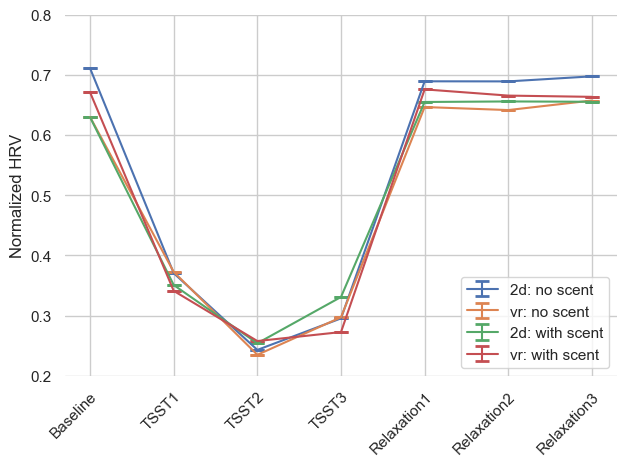

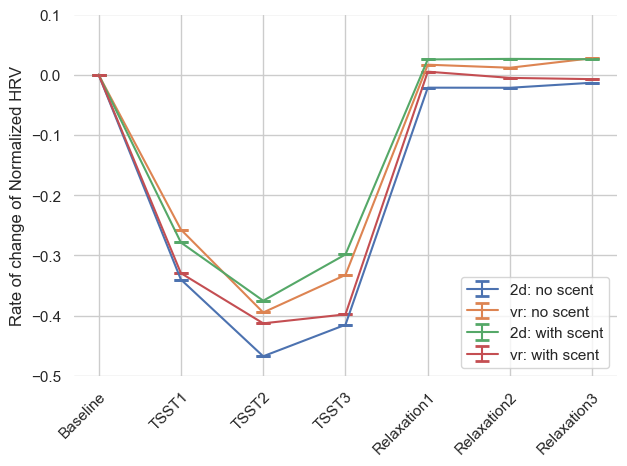

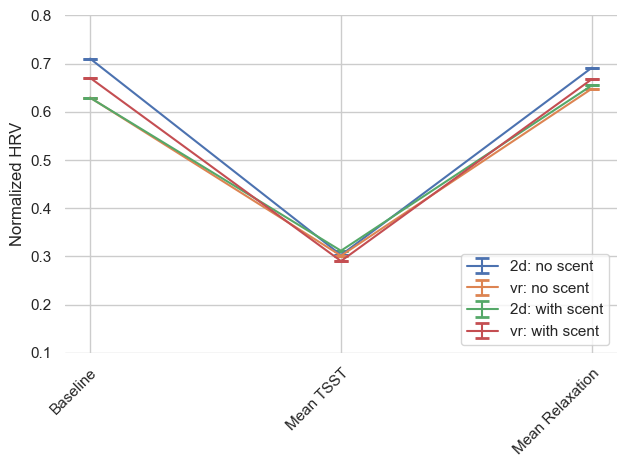

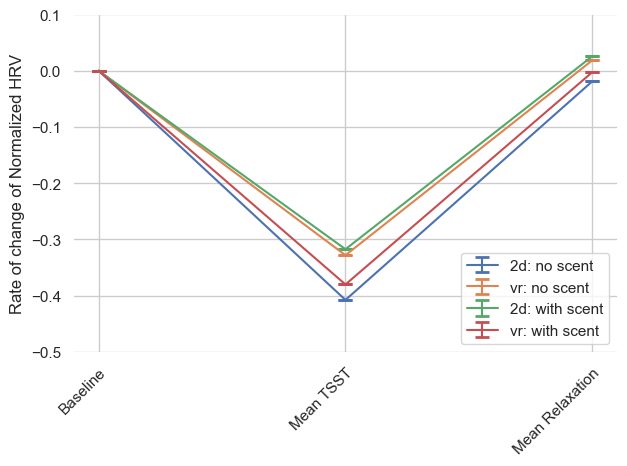

In [135]:

import matplotlib.pyplot as mpl
mpl.rcParams['font.size'] = 11
######------------------------------------------------------------------------------------
#######---------------------------------Normalized IBI------------------------------------
#######-----------------------------------------------------------------------------------
#mpl.rcParams["font.family"]="cursive"

x_labels = ["Baseline", "TSST1", "TSST2", "TSST3", "Relaxation1", "Relaxation2", "Relaxation3"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots()
    
ax.errorbar(x_pos,  list(mean_norm_ibi_no_scent_2d),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_norm_ibi_no_scent_vr),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_norm_ibi_scent_2d),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_norm_ibi_scent_vr),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Normalized HRV")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.ylim(0.2, 0.8) 
plt.tight_layout()
plt.show()


#####------------------------------------------------------
######-------------Rate of change of IBI-------------------
######-----------------------------------------------------
mean_norm_ibi_no_scent_2d_slope=get_cumsum_cond(mean_norm_ibi_no_scent_2d)
mean_norm_ibi_no_scent_vr_slope =get_cumsum_cond(mean_norm_ibi_no_scent_vr)
mean_norm_ibi_scent_2d_slope = get_cumsum_cond(mean_norm_ibi_scent_2d)
mean_norm_ibi_scent_vr_slope =get_cumsum_cond(mean_norm_ibi_scent_vr)



fig, ax = plt.subplots()    
ax.errorbar(x_pos,  list(mean_norm_ibi_no_scent_2d_slope),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_norm_ibi_no_scent_vr_slope),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_norm_ibi_scent_2d_slope),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_norm_ibi_scent_vr_slope),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Rate of change of Normalized HRV")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.ylim(-0.5, 0.1) 
plt.tight_layout()
plt.show()

#####--------------------------------------------------------------------------------------------------
#################--------------------------------Baseline, Stress, relaxation--------------------------------
####--------------------------------------------------------------------------------------------------

x_labels = ["Baseline", "Mean TSST", "Mean Relaxation"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots()
 
mean_norm_ibi_no_scent_2d_short = split_bpm (mean_norm_ibi_no_scent_2d)
mean_norm_ibi_no_scent_vr_short =split_bpm(mean_norm_ibi_no_scent_vr) 
mean_norm_ibi_scent_2d_short = split_bpm(mean_norm_ibi_scent_2d)
mean_norm_ibi_scent_vr_short = split_bpm(mean_norm_ibi_scent_vr)

ax.errorbar(x_pos,  list(mean_norm_ibi_no_scent_2d_short),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_norm_ibi_no_scent_vr_short),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_norm_ibi_scent_2d_short),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_norm_ibi_scent_vr_short),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Normalized HRV")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.ylim(0.1, 0.8) 
plt.tight_layout()
plt.show()


######-------------------------------------------------------------------------
#######------------------------------------------------------------------------
#######------------------------------------------------------------------------
fig, ax = plt.subplots()

mean_norm_ibi_no_scent_2d_short_slope=get_cumsum_cond(mean_norm_ibi_no_scent_2d_short)
mean_norm_ibi_no_scent_vr_short_slope =get_cumsum_cond(mean_norm_ibi_no_scent_vr_short)
mean_norm_ibi_scent_2d_short_slope = get_cumsum_cond(mean_norm_ibi_scent_2d_short)
mean_norm_ibi_scent_vr_short_slope =get_cumsum_cond(mean_norm_ibi_scent_vr_short)

ax.errorbar(x_pos,  list(mean_norm_ibi_no_scent_2d_short_slope),  yerr=0, capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(mean_norm_ibi_no_scent_vr_short_slope),  yerr=0, capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(mean_norm_ibi_scent_2d_short_slope),  yerr=0, capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(mean_norm_ibi_scent_vr_short_slope),  yerr=0, capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Rate of change of Normalized HRV")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.ylim(-0.5, 0.1) 
plt.tight_layout()
plt.show()

In [136]:
no_scent_2d_ibi_mean_change=calc_rate_change_percent(mean_norm_ibi_no_scent_2d_short_slope) 
no_scent_vr_ibi_mean_change=calc_rate_change_percent(mean_norm_ibi_no_scent_vr_short_slope) 
scent_2d_ibi_mean_change=calc_rate_change_percent(mean_norm_ibi_scent_2d_short_slope)
scent_vr_ibi_mean_change=calc_rate_change_percent(mean_norm_ibi_scent_vr_short_slope)

In [137]:
print ("change of normalized HRV from stress to relaxation, scent vr: " + str(scent_vr_ibi_mean_change) +" %")
print ("change of normalized HRV from stress to relaxation, no scent vr: " + str(no_scent_vr_ibi_mean_change) +" %")
print ("change of normalized HRV from stress to relaxation, scent 2d: " + str(scent_2d_ibi_mean_change) +" %")
print ("change of normalized HRV from stress to relaxation, no scent 2d: " + str(no_scent_2d_ibi_mean_change) +" %")

change of normalized HRV from stress to relaxation, scent vr: 99.33628543642362 %
change of normalized HRV from stress to relaxation, no scent vr: 105.65754133154373 %
change of normalized HRV from stress to relaxation, scent 2d: 108.12559461423936 %
change of normalized HRV from stress to relaxation, no scent 2d: 95.38361102162327 %


In [138]:
mean_norm_ibi_no_scent_2d_short

[0.7105760719511464, 0.30292460698090584, 0.6917572946520689]

In [139]:
no_scent_2d_ibi_mean_change


95.38361102162327

In [140]:
mean_norm_ibi_no_scent_2d_short_slope

array([ 0.        , -0.40765146, -0.01881878])